In [1239]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy import signal
import pandas as pd
from scipy.sparse import random as sparse_random
from scipy.sparse import csr_matrix

from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler


network output is defined as (pg 547):

$$z(t) = \mathbf{w}^T \mathbf{r}(t)$$

network error function (pg 547):

$$e_-(t) = \mathbf{w}^T(t - \Delta t)\mathbf{r}(t) - f(t)$$

nb! this is the error right before the weights are updated at time t. The idea is to update the weights from $\mathbf{w}(t-\Delta t) \text{ to } \mathbf{w}(t)$ in such a way as to reduce the magnitude of $e_-(t)$

So, immediately after the weight update, the netwrok output, **z**, is $\mathbf{w}^T(t)\mathbf{r}(t)$, if the weights are updated fast enough.

So, the error __after__ the weight update is $$ e_+(t) = \mathbf{w}^T(t) \mathbf{r}(t) - f(t) $$


THE goal, then, is to reduce errors in the network by making $$|e_+(t)| < |e_-(t)|$$ and converging to a solution so that the weight vecotr no longer needs to be updated (pg. 548)

this means that $$\frac{e_+(t)}{e_-(t)} \rightarrow 1$$ by the end of training (pg 548)

accomplished by steady but small reduction in $e_-$ and $e_+$ over time, except for the first update which is large (pg 548). So you also want to have $\Delta t$ be pretty short to accomplish this

## Recursive Least Squares

(Why?)

RLS: $$\mathbf{w}(t) = \mathbf{w}(t - \Delta t) - e_-(t) \mathbf{P}(t) \mathbf{r}(t)$$

where **P** is an NxN matrix that is updated at the same time as the weights according to the rule: 
$$\mathbf{P}(t) = \mathbf{P}(t - \Delta t) - \frac{\mathbf{P}(t - \Delta t) \mathbf{r}(t) \mathbf{r}^T \mathbf{P}(t - \Delta t)}{1 + \mathbf{r}^T(t)\mathbf{P}(t - \Delta t) \mathbf{r}(t)}$$

Where $$\mathbf{P}(0) = \frac{\mathbf{I}}{\alpha}$$
Where **I** is the identity matrix, and $\alpha$ is a constant (pg. 548)

Where **P** acts a a multidimensional learning rate for the 'delta' type learning rule. So, for this algorithm, **P** is a "Running estimate  of the inverse of teh correlation matrix of the network rates **r** plus a regularization term: $$\mathbf{P} = \left( \sum_t \mathbf{r}(t)\mathbf{r}^T(t) + 
\alpha \mathbf{I} \right)$$

For subsequent timesteps, the equation above imply that: $$e_+(t) = e_-(t)(1 - \mathbf{r}^T (t) \mathbf{P}(t)\mathbf{r}(t))$$
(pg 548) so the quantity $\mathbf{r}^T\mathbf{P}\mathbf{r}$ varies from around 1 to assymptotically approaching 0 over the course of training, and is always positive

$\alpha$ acts as the learning rate, and should be adjusted depending on the target function. (pg548). small values for $\alpha$ result in fast learning but sometimes can become unstable. But, if $\alpha$ is too big, FORCE might not be able to keep the output close to the target for long enough. use between 1 and 100 (pg 548)

Learning generally takes about $1000 \tau$ where $\tau$ is the basic time constant of the network, which they set to around 10ms. So basically it takes around 10 seconds of simulated time for teh network to converge (549)

"To encompass all the models, we write the newtwork equations for the generator network as: 
$$\tau \frac{dx_i}{dt} = -x_i + g_{GG} \sum_{j = 1}^{N_G}J_{ij}^{GG} r_j + g_{G_z} J_{i} ^{G_z} z + g_{GF} \sum_{a = 1}^{N_F} J_{ia}^{GF} s_a + \sum_{\mu = 1}^{N_I} J_{i \mu}^{GI} I_\mu$$

for $i = 1, 2, .. <1,2,..>, N_G$ with firing rates $r_i = \tanh(x_i$) (pg 556)

For figure 2 and 3, the parameters are:

$$N_G = 1000\\
p_{GG} = 0.1\\
p_Z = 1\\
g_{GG} = 1.5\\
g_{Gz} = 1\\
g_{GF} = 0\\
\alpha = 1.0\\
N_I = 0\\
\tau = 10ms$$

### Set up the sparse matrix

In [98]:
# Parameters
N = 1000
p = 0.1
g = 1.5  # g greater than 1 leads to chaotic networks.
alpha = 1.0
dt = 0.1

np.random.seed(0)
# Scale factor
scale = 1.0 / np.sqrt(p * N)

# Generate sparse random matrix
M_sparse = sparse_random(N, N, density=p, format='csr', dtype=np.float64, random_state=0)
M_sparse.data = np.random.randn(M_sparse.nnz)  # Replace non-zero elements with normally distributed values

# Scale and convert to a dense matrix
M = M_sparse * g * scale
M = M.toarray()

# Display some properties of M for verification
print(f"Matrix M shape: {M.shape}")
print(f"Matrix M density: {np.count_nonzero(M) / M.size}")


Matrix M shape: (1000, 1000)
Matrix M density: 0.1


### Set up the network class:

In [1382]:
class GenNetv2:
    def __init__(self, N, alpha, g, p, delta):
        # attributes from setup
        self.N = N
        self.alpha = alpha
        self.g = g
        self.p = p
        self.delta = delta

        # general network attributes
        self.P = np.eye(N)/self.alpha
        self.M = self._init_synaptic_matrix()
        self.weights = (np.random.rand(N, 1) * 0.5) /np.sqrt(self.N)
        self.output = (np.random.rand(1, 1) * 0.5)
        np.random.seed(3)
        self.neurons = np.random.rand(N, 1) * 0.5
        np.random.seed(5)
        self.wf = 2.0 * (np.random.rand(N, 1) - 0.5) #wtf?
        self.error = 0.0
        self.activation = np.tanh(self.neurons)

    def _init_synaptic_matrix(self):
        
        # Scale factor
        scale = 1.0 / np.sqrt(self.p * self.N)

        # Generate sparse random matrix
        M_sparse = sparse_random(self.N, self.N, density=self.p, format='csr', dtype=np.float64, random_state=42)
        np.random.seed(44)
        M_sparse.data = np.random.randn(M_sparse.nnz)  # Replace non-zero elements with normally distributed values

        # Scale and convert to a dense matrix
        M = M_sparse * self.g * scale
        np.random.seed(None)
        return M.toarray()

    def neuron_activity(self):
        return (1.0 - self.delta) * self.neurons + self.M @ (self.activation * self.delta) \
            + self.wf * (self.output * self.delta)
    
    def net_output(self):
        return self.weights.T @ self.activation
    
    def get_error(self, function, timestep):
        return self.output - function[timestep]
    
    def weight_update(self):
        return self.weights - self.error * self.P @ self.activation

    def P_update(self):
        # numerator = self.P @ self.activation @ self.activation.T @ self.P
        # denominator = 1 + self.activation.T @ self.P @ self.activation
        k = self.P @ self.activation
        rPr = self.activation.T @ k
        c = 1.0 / (1.0 + rPr)
        return self.P - k @ (k.T * c)
        # self.P = self.P - (numerator)/(denominator) #Why does this version take way longer to run?

    def spontaneus_activity(self, timesteps):
        evolution = np.zeros(timesteps)
        evolution[0] = self.output

        neuron_dict = {13: np.zeros(timesteps), 44: np.zeros(timesteps), 
                       523: np.zeros(timesteps), 123: np.zeros(timesteps), 
                       3: np.zeros(timesteps), 14: np.zeros(timesteps), 
                       155: np.zeros(timesteps), 1: np.zeros(timesteps), 
                       99: np.zeros(timesteps), 25: np.zeros(timesteps)}
        
        weight_array = np.zeros((len(self.weights), timesteps))

        weight_mag_array = np.zeros((timesteps))
        
        activity_array = np.zeros((len(self.activation), timesteps))

        for time in range(timesteps):
            self.neurons = self.neuron_activity()
            self.activation = np.tanh(self.neurons)
            self.output = self.net_output()
            evolution[time] = self.output
            
            
            w1 = self.weights

            activity_array[:, time] = self.activation.reshape(len(self.activation))

            for key in neuron_dict:
                neuron_dict[key][time] = self.activation[key]
            
            w2 = self.weights
            
            weight_array = np.zeros((len(self.weights), timesteps))

            weight_mag_array[time] = np.linalg.norm(np.gradient(w2 - w1, self.delta, axis=0))
            
        return evolution, neuron_dict, weight_array, weight_mag_array, activity_array

    #training the network
    def train(self, function, timesteps, learn_every):
        func_to_approx = function 
        evolution = np.zeros(timesteps)
        evolution[0] = self.output

        # Dictionary to store the activity of specific neurons
        neuron_dict = {13: np.zeros(timesteps), 44: np.zeros(timesteps), 
                       523: np.zeros(timesteps), 123: np.zeros(timesteps), 
                       3: np.zeros(timesteps), 14: np.zeros(timesteps), 
                       155: np.zeros(timesteps), 1: np.zeros(timesteps), 
                       99: np.zeros(timesteps), 25: np.zeros(timesteps)}
        for key in neuron_dict: #store first value
            neuron_dict[key][0] = self.activation[key]
        
        weight_array = np.zeros((len(self.weights), timesteps))
        weight_array[:, 0] = self.weights.reshape(len(self.weights))
        # Array to store the norm of the derivative of the weight array
        weight_mag_array = np.zeros((timesteps))
        # store first value
        weight_mag_array[0] = 0
        
        activity_array = np.zeros((len(self.activation), timesteps))
        activity_array[:, 0] = self.activation.reshape(len(self.activation))

        #train
        for time in range(1, timesteps):
            # Neuron and activation update
            self.neurons = self.neuron_activity()
            self.activation = np.tanh(self.neurons)
            self.output = self.net_output()
            evolution[time] = self.output
            
            #get weights at time t
            w1 = self.weights

            activity_array[:, time] = self.activation.reshape(len(self.activation))
            
            #store nueorn activity
            for key in neuron_dict:
                neuron_dict[key][time] = self.activation[key]
        
            # Learning updates
            if time & learn_every == 0:
                self.error = self.get_error(func_to_approx, time)
                self.P = self.P_update()
                self.weights = self.weight_update()
            
            #get weights at time t+1
            w2 = self.weights

            weight_array[:, time] = self.weights.reshape(len(self.weights))
            
            #store weight gradient magnitude in array 
            weight_mag_array[time] = np.linalg.norm(np.gradient(w2 - w1, self.delta, axis=0))
                
        return evolution, neuron_dict, weight_array, weight_mag_array, activity_array

### Spontaneous chaos

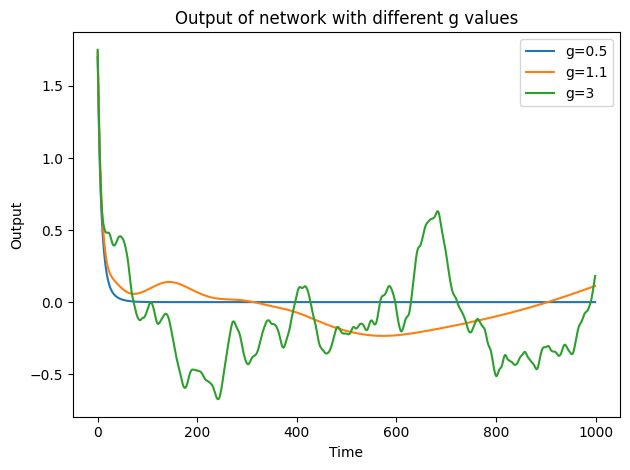

In [1229]:
# small_g_net = GenNetv2(N, 1.0, 0.5, 0.1, 0.1)
# sge, snd, _, _, _ = small_g_net.spontaneus_activity(1000)

# medium_g_net = GenNetv2(N, 1.0, 1.1, 0.1, 0.1)
# mge, mnd, _, _, _ = medium_g_net.spontaneus_activity(1000)

# big_g_net = GenNetv2(N, 1.0, 3, 0.1, 0.1)
# bge, bnd, _, _, _ = big_g_net.spontaneus_activity(1000)

fig, ax = plt.subplots()
ax.plot(sge, label='g=0.5')
ax.plot(mge, label='g=1.1')
ax.plot(bge, label='g=3')
ax.set_xlabel('Time')
ax.set_ylabel('Output')
ax.legend()
ax.set_title('Output of network with different g values')
fig.tight_layout()
fig.savefig('output_g_values.png', dpi=600)
plt.show()

### Fig 1 ABC

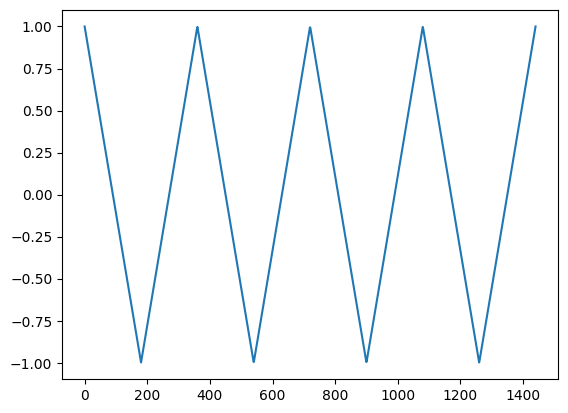

In [483]:
# First function
time_abc = np.linspace(0, 1440, 1440)
triangle = -signal.sawtooth(2 * np.pi * 4 * time_abc, 0.5)
plt.plot(time_abc, triangle)

In [1136]:
# Instantiate object
abc_net = GenNetv2(1000, 1.0, 1.5, 0.1, 0.1)

In [1137]:
first, n_1, _, w_1, _ = abc_net.spontaneus_activity(1440)
second, n_2, _, w_2, _ = abc_net.train(triangle, 1440, 2)
third, n_3, _, w_3, _ = abc_net.spontaneus_activity(770)

In [1138]:
network_activity = np.append(first, second)
network_activity = np.append(network_activity, third[:770])

for k, v in n_1.items():
    n_2[k] = np.append(v, n_2[k])
    n_3[k] = np.append(n_2[k], n_3[k])

neuron_activity = n_3

weight_activity = np.append(w_1, w_2)
weight_activity = np.append(weight_activity, w_3[:770])


function = np.append(triangle, triangle)
function = np.append(function, triangle[:770])

In [377]:
n_3.keys()

dict_keys([13, 44, 523, 123, 3, 14, 155, 1, 99, 25])

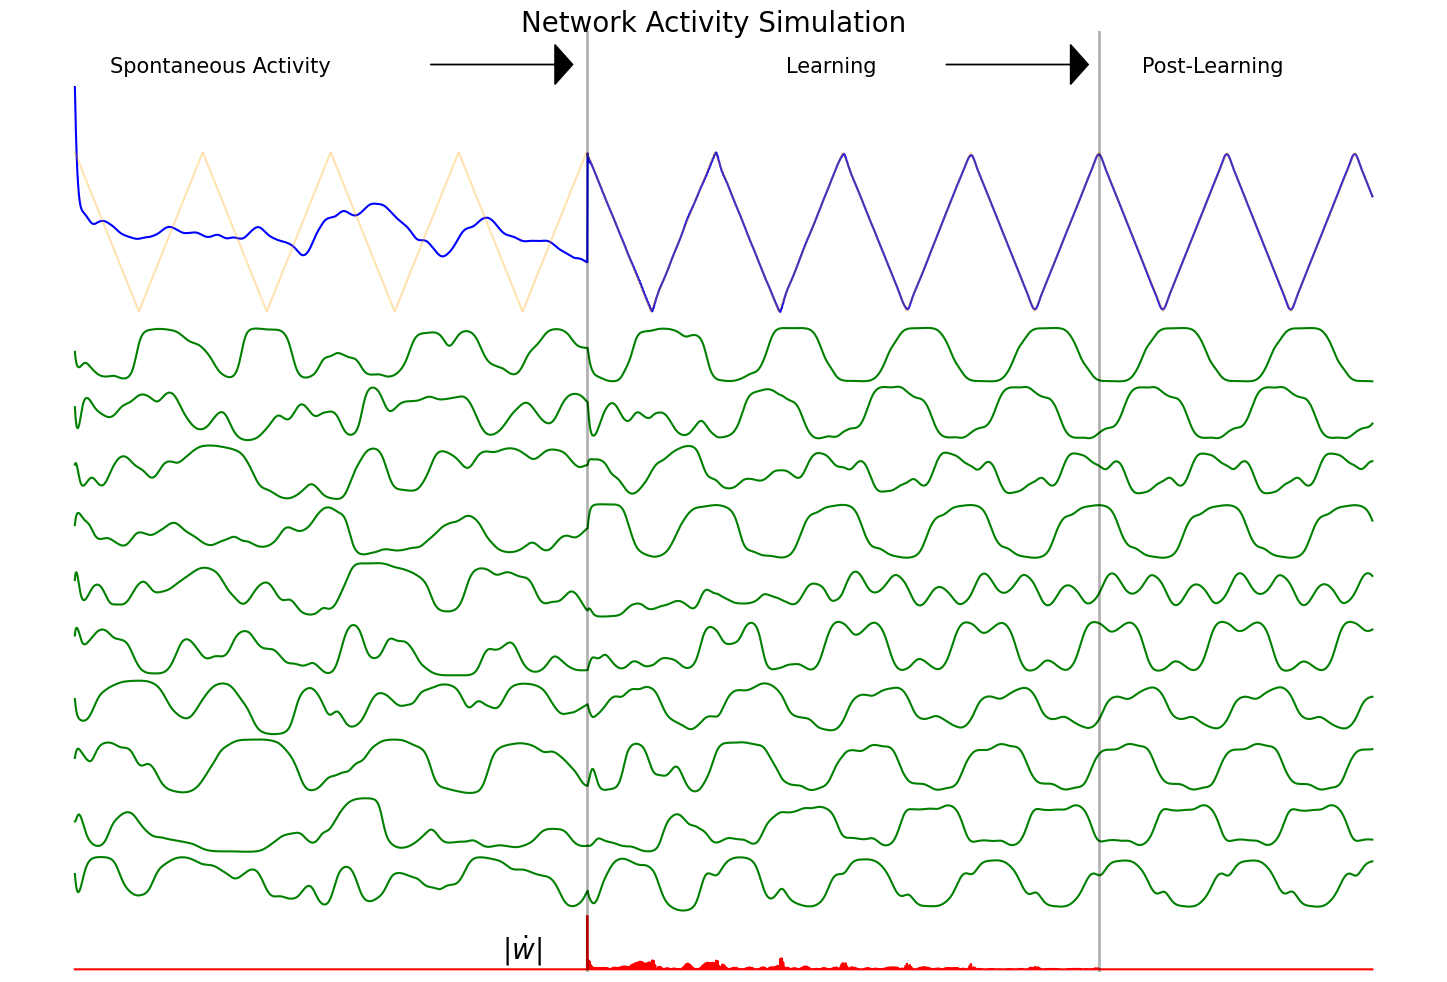

In [1431]:
# Create a figure
fig = plt.figure(figsize=(15, 10))

# Mandatory crazy matplotlib code to get the right formating 
gs = gridspec.GridSpec(16, 1)

# Create the subplots with different sizes
ax1 = fig.add_subplot(gs[0:5, 0])  # this axis will span 5 rows so we can see the activity properly
ax2 = fig.add_subplot(gs[5, 0])
ax3 = fig.add_subplot(gs[6, 0])
ax4 = fig.add_subplot(gs[7, 0])
ax5 = fig.add_subplot(gs[8, 0])
ax6 = fig.add_subplot(gs[9, 0])
ax7 = fig.add_subplot(gs[10, 0])
ax8 = fig.add_subplot(gs[11, 0])
ax9 = fig.add_subplot(gs[12, 0])
ax10 = fig.add_subplot(gs[13, 0])
ax11 = fig.add_subplot(gs[14, 0])
ax12 = fig.add_subplot(gs[15, 0])

fig.tight_layout()
fig.subplots_adjust(hspace = 0)


ax1.plot(network_activity, color='blue')
ax1.plot(function, alpha=0.3, color='orange')
ax1.set_frame_on(False)
ax1.axis('off')
ax1.axvline(1440, linewidth=2, alpha=0.3, color='black')
ax1.axvline(2880, linewidth=2, alpha=0.3, color='black')
ax1.text(100, 2, 'Spontaneous Activity', color='black', fontsize=15)
ax1.arrow(1000, 2.1, 350, 0, head_width=0.5, head_length=50, fc='black', ec='black')
ax1.text(2000, 2, 'Learning', color='black', fontsize=15)
ax1.arrow(2450, 2.1, 350, 0, head_width=0.5, head_length=50, fc='black', ec='black')
ax1.text(3000, 2, 'Post-Learning', color='black', fontsize=15)

ax2.plot(neuron_activity[13], color='green')
ax2.set_frame_on(False)
ax2.axis('off')
ax2.axvline(1440, linewidth=2, alpha=0.3, color='black')
ax2.axvline(2880, linewidth=2, alpha=0.3, color='black')


ax3.plot(neuron_activity[44], color='green')
ax3.set_frame_on(False)
ax3.axis('off')
ax3.axvline(1440, linewidth=2, alpha=0.3, color='black')
ax3.axvline(2880, linewidth=2, alpha=0.3, color='black')


ax4.plot(neuron_activity[523], color='green')
ax4.set_frame_on(False)
ax4.axis('off')
ax4.axvline(1440, linewidth=2, alpha=0.3, color='black')
ax4.axvline(2880, linewidth=2, alpha=0.3, color='black')


ax5.plot(neuron_activity[123], color='green')
ax5.set_frame_on(False)
ax5.axis('off')
ax5.axvline(1440, linewidth=2, alpha=0.3, color='black')
ax5.axvline(2880, linewidth=2, alpha=0.3, color='black')


ax6.plot(neuron_activity[3], color='green')
ax6.set_frame_on(False)
ax6.axis('off')
ax6.axvline(1440, linewidth=2, alpha=0.3, color='black')
ax6.axvline(2880, linewidth=2, alpha=0.3, color='black')


ax7.plot(neuron_activity[14], color='green')
ax7.set_frame_on(False)
ax7.axis('off')
ax7.axvline(1440, linewidth=2, alpha=0.3, color='black')
ax7.axvline(2880, linewidth=2, alpha=0.3, color='black')


ax8.plot(neuron_activity[155], color='green')
ax8.set_frame_on(False)
ax8.axis('off')
ax8.axvline(1440, linewidth=2, alpha=0.3, color='black')
ax8.axvline(2880, linewidth=2, alpha=0.3, color='black')


ax9.plot(neuron_activity[1], color='green')
ax9.set_frame_on(False)
ax9.axis('off')
ax9.axvline(1440, linewidth=2, alpha=0.3, color='black')
ax9.axvline(2880, linewidth=2, alpha=0.3, color='black')


ax10.plot(neuron_activity[99], color='green')
ax10.set_frame_on(False)
ax10.axis('off')
ax10.axvline(1440, linewidth=2, alpha=0.3, color='black')
ax10.axvline(2880, linewidth=2, alpha=0.3, color='black')


ax11.plot(neuron_activity[25], color='green')
ax11.set_frame_on(False)
ax11.axis('off')
ax11.axvline(1440, linewidth=2, alpha=0.3, color='black')
ax11.axvline(2880, linewidth=2, alpha=0.3, color='black')


ax12.plot(weight_activity, color='red')
ax12.set_frame_on(False)
ax12.axis('off')
ax12.axvline(1440, linewidth=2, alpha=0.3, color='black')
ax12.axvline(2880, linewidth=2, alpha=0.3, color='black')
ax12.text(1200, 0.1, r'$|\dot{w}|$', color='black', fontsize=20)

fig.suptitle('Network Activity Simulation', fontsize=20, y=1.001)


plt.show()

fig.savefig('network_activity.png', dpi=600)


## Figure D:

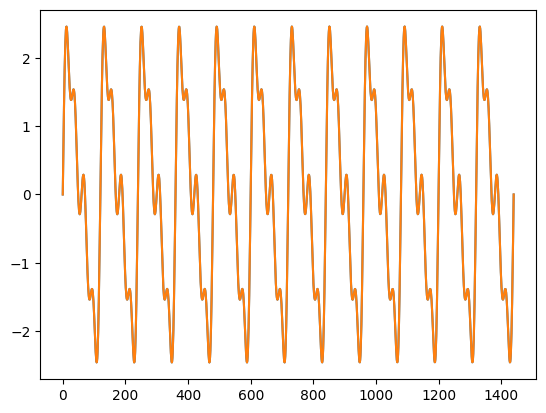

In [1242]:
amp = 1.3
freq = 1/60
time_d = np.linspace(0, 1440, 1440)  

# Compute ft
ft = (amp/1.0)*np.sin(1.0*np.pi*freq*time_d) + \
     (amp/2.0)*np.sin(2.0*np.pi*freq*time_d) + \
     (amp/6.0)*np.sin(3.0*np.pi*freq*time_d) + \
     (amp/3.0)*np.sin(4.0*np.pi*freq*time_d)
ft = ft / 1.5

# Compute ft2
ft2 = (amp/1.0)*np.sin(1.0*np.pi*freq*time_d) + \
      (amp/2.0)*np.sin(2.0*np.pi*freq*time_d) + \
      (amp/6.0)*np.sin(3.0*np.pi*freq*time_d) + \
      (amp/3.0)*np.sin(4.0*np.pi*freq*time_d)
ft2 = ft2 / 1.5

# Print or plot the results
f_d = ft + ft2
plt.plot(f_d)
plt.show()

In [1116]:
d_net.output

array([[0.06499221]])

In [1129]:
d_net = GenNetv2(1000, 1.0, 1.5, 0.1, 0.1)
train_evol_d, _, _, _, _ = d_net.train(f_d, len(time_d), 2)
post_evol_d, _, _, _, _ = d_net.spontaneus_activity(len(time_d))

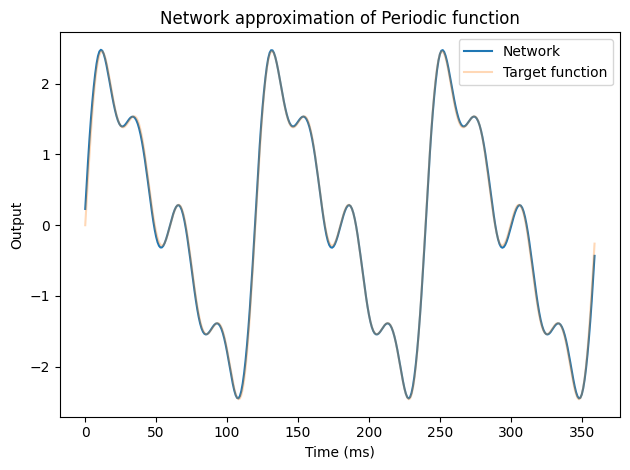

In [1397]:
fig, ax = plt.subplots()
ax.plot(post_evol_d[:360], label='Network')
ax.plot(f_d[:360], alpha=0.3, label='Target function')
ax.legend()
# ax.set_frame_on(False)
# ax.axis('off')
ax.set_title('Network approximation of Periodic function')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Output')
fig.tight_layout()
fig.savefig('periodic_d.png', dpi=600)
plt.show()

### Fig E

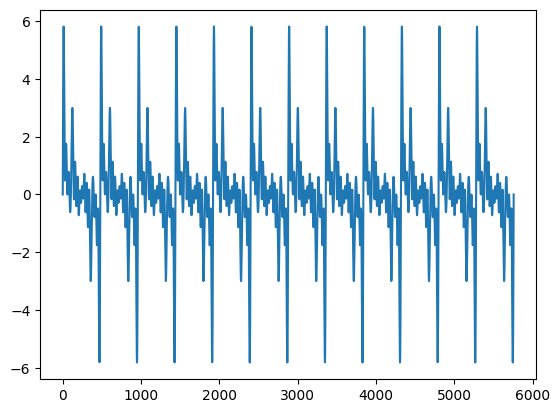

In [1187]:
amp = 1.3
freq = 1/60
time_e = np.linspace(0, 360, 1440)  

# Compute ft
ft_e = (amp/1.0)*np.sin(1.0*np.pi*freq*time_e) + \
     (amp/2.0)*np.sin(2.0*np.pi*freq*time_e) + \
     (amp/6.0)*np.sin(3.0*np.pi*freq*time_e) + \
     (amp/3.0)*np.sin(4.0*np.pi*freq*time_e) + \
     (amp/1.0)*np.sin(5.0*np.pi*freq*time_e) + \
     (amp/2.0)*np.sin(6.0*np.pi*freq*time_e) + \
     (amp/6.0)*np.sin(7.0*np.pi*freq*time_e) + \
     (amp/3.0)*np.sin(8.0*np.pi*freq*time_e) + \
     (amp/1.0)*np.sin(9.0*np.pi*freq*time_e) + \
     (amp/2.0)*np.sin(10.0*np.pi*freq*time_e) + \
     (amp/6.0)*np.sin(11.0*np.pi*freq*time_e) + \
     (amp/3.0)*np.sin(12.0*np.pi*freq*time_e) +\
     (amp/1.0)*np.sin(13.0*np.pi*freq*time_e) + \
     (amp/2.0)*np.sin(14.0*np.pi*freq*time_e) + \
     (amp/6.0)*np.sin(15.0*np.pi*freq*time_e) + \
     (amp/3.0)*np.sin(16.0*np.pi*freq*time_e)
ft_e = ft_e / 1.5

# Compute ft2
ft2_e = (amp/1.0)*np.sin(1.0*np.pi*freq*time_e) + \
     (amp/2.0)*np.sin(2.0*np.pi*freq*time_e) + \
     (amp/6.0)*np.sin(3.0*np.pi*freq*time_e) + \
     (amp/3.0)*np.sin(4.0*np.pi*freq*time_e) + \
     (amp/1.0)*np.sin(5.0*np.pi*freq*time_e) + \
     (amp/2.0)*np.sin(6.0*np.pi*freq*time_e) + \
     (amp/6.0)*np.sin(7.0*np.pi*freq*time_e) + \
     (amp/3.0)*np.sin(8.0*np.pi*freq*time_e) + \
     (amp/1.0)*np.sin(9.0*np.pi*freq*time_e) + \
     (amp/2.0)*np.sin(10.0*np.pi*freq*time_e) + \
     (amp/6.0)*np.sin(11.0*np.pi*freq*time_e) + \
     (amp/3.0)*np.sin(12.0*np.pi*freq*time_e) +\
     (amp/1.0)*np.sin(13.0*np.pi*freq*time_e) + \
     (amp/2.0)*np.sin(14.0*np.pi*freq*time_e) + \
     (amp/6.0)*np.sin(15.0*np.pi*freq*time_e) + \
     (amp/3.0)*np.sin(16.0*np.pi*freq*time_e)
ft2_e = ft2 / 1.5

# Print or plot the results
f_e = ft_e + ft2_e
f_e_4 = np.concatenate([f_e, f_e, f_e, f_e])
plt.plot(f_e_4)
plt.show()

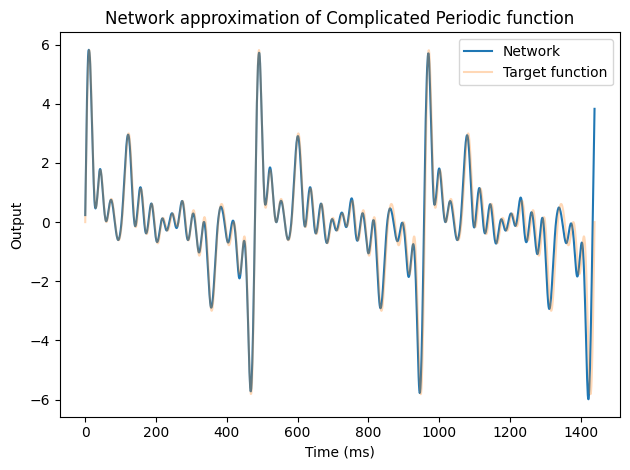

In [1400]:
# e_net = GenNetv2(1000, 1.0, 1.5, 0.1, 0.1)
# train_e, _, _, _, _= e_net.train(f_e_4, len(f_e_4), 2)
# periodic_e, _, _, _, _= e_net.spontaneus_activity(1440)
fig, ax = plt.subplots()
ax.plot(periodic_e, label='Network')
ax.plot(f_e, alpha=0.3, label='Target function')
ax.set_title('Network approximation of Complicated Periodic function')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Output')
ax.legend()
fig.tight_layout()
fig.savefig('complicated_periodic.png', dpi=600)
plt.show()


### Fig F

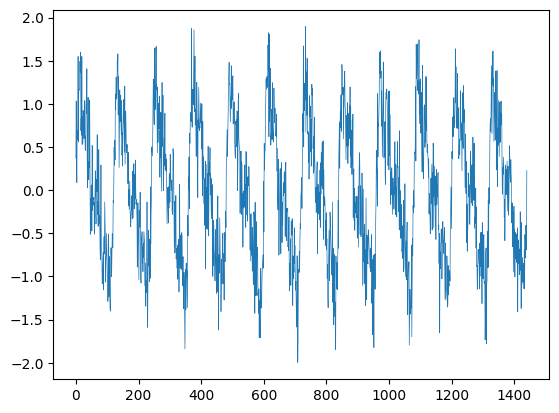

In [546]:
time_f = np.linspace(0, 1440, 1440)

def noisy_four_sinusoids(t):
    np.random.seed(None) 
    
    amp = 1.3 
    freq = 1/60
    f1 = (amp / 1.0) * np.sin(1.0 * np.pi * freq * t)
    f2 = (amp / 2.0) * np.sin(2.0 * np.pi * freq * t)
    f3 = (amp / 3.0) * np.sin(4.0 * np.pi * freq * t)
    f4 = (amp / 6.0) * np.sin(3.0 * np.pi * freq * t)
    
    return (f1+f2+f3+f4)/1.5 + 0.3*np.random.normal(0,1)

noisy_sins = [noisy_four_sinusoids(t) for t in time_f]
plt.plot(time_f,noisy_sins,linewidth=0.5)

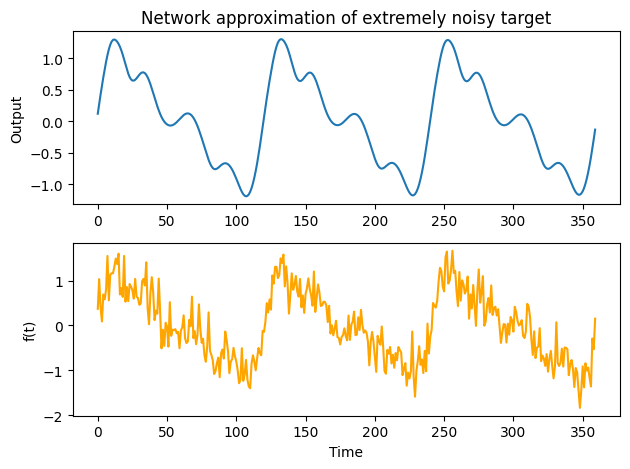

In [1407]:
# f_net = GenNetv2(1000, 1.0, 1.5, 0.1, 0.1)
# f_net.spontaneus_activity(1440)
# train_f, _, _, _, _ = f_net.train(noisy_sins, len(time_f), 2)
# periodic_f, _, _, _, _ = f_net.spontaneus_activity(1440)

fig = plt.figure()
gs = gridspec.GridSpec(2, 1)


ax = fig.add_subplot(gs[0, 0])

ax.set_title('Network approximation of extremely noisy target')
ax.plot(periodic_f[:360], label='Network')
ax.set_ylabel('Output')

ax2 = fig.add_subplot(gs[1, 0])

ax2.plot(noisy_sins[:360], color='orange', label='Target function')
ax2.set_xlabel('Time')
ax2.set_ylabel('f(t)')
fig.tight_layout()
fig.savefig('noisy_target.png', dpi=600)
plt.show()


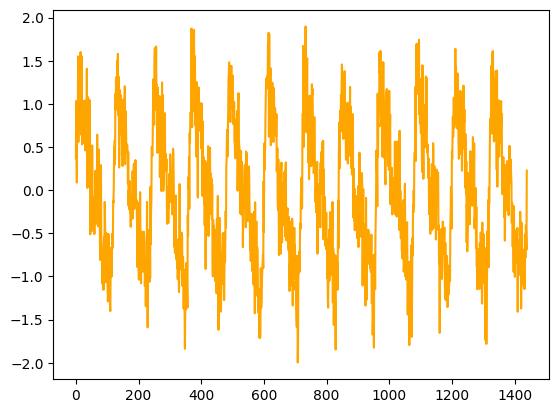

In [551]:
plt.plot(noisy_sins, color = 'orange')

### Fig G

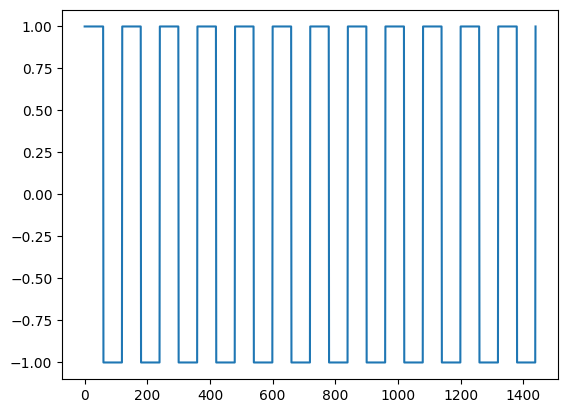

In [653]:
time_g = np.linspace(0, 1440, 1440)

def square_wave(t):
    freq = 1/120
    return signal.square(2*np.pi*freq*t)

plt.plot(square_wave(time_g))

In [978]:
wave_g = np.concatenate([square_wave(time_g), square_wave(time_g), square_wave(time_g), square_wave(time_g)])

In [979]:
g_net = GenNetv2(1000, 1.0, 1.5, 0.1, 0.1)
g_net.train(wave_g, len(wave_g), 2)
activity_g, _, _, _, _ = g_net.spontaneus_activity(440)

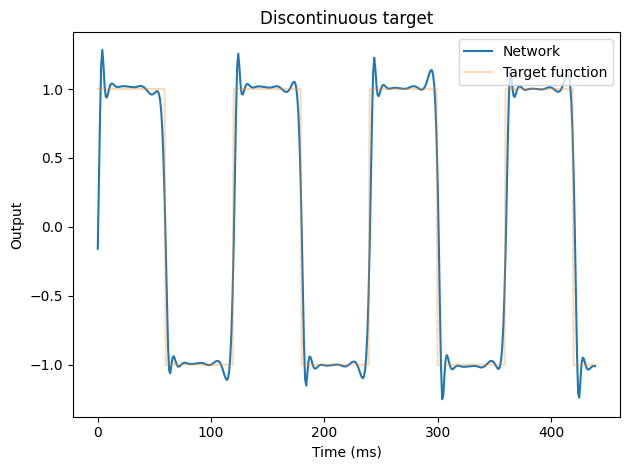

In [1402]:
fig, ax = plt.subplots()
ax.set_title('Network approximation of discontinuous target')
ax.plot(activity_g, label='Network')
ax.plot(square_wave(np.arange(440)), alpha=0.3, label='Target function')
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Output')
ax.legend(loc='upper right')
fig.tight_layout()
fig.savefig('discontinuous.png', dpi=600)
plt.show()


## Fig I

In [636]:
import numpy as np
import matplotlib.pyplot as plt

def generate_sine_wave(period, num_points=1440):

    # Define the time array
    t = np.linspace(0, num_points, num_points)
    
    # Compute the sine wave values
    y = np.sin((2 * np.pi / period) * t)
    
    return t, y

# Example usage
tau = 10  # Define tau

# Generate the sine wave with period 6*tau
t1, lil_tau = generate_sine_wave(6 * tau, 600)

# Generate the sine wave with period 800*tau
t2, big_tau = generate_sine_wave(800 * tau, 8000)

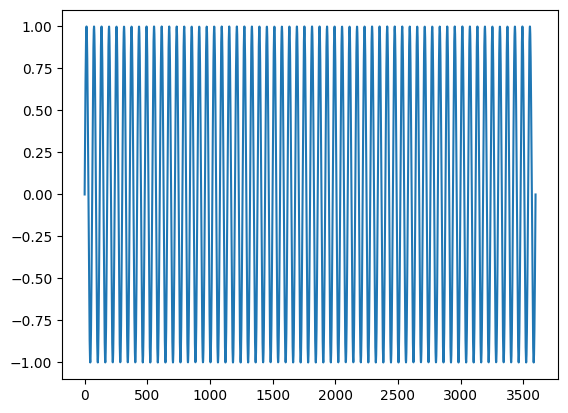

In [972]:
lil_tau_4 = np.concatenate([lil_tau, lil_tau, lil_tau, lil_tau, lil_tau, lil_tau])
plt.plot(lil_tau_4)
plt.show()

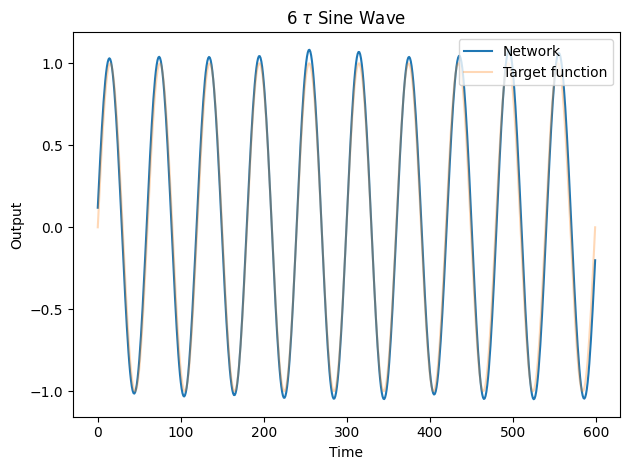

In [1420]:
# i_small_net = GenNetv2(1000, 1.0, 1.5, 0.1, 0.1)
# train_evol_i_small, _, _, _, _ = i_small_net.train(lil_tau_4, len(lil_tau_4), 2)
# post_evol_i_small, _, _, _, _ = i_small_net.spontaneus_activity(600)
fig, ax = plt.subplots()
ax.set_title(r'6 $\tau$ Sine Wave ')
ax.plot(post_evol_i_small, label='Network')
ax.plot(lil_tau, alpha=0.3, label='Target function')
ax.set_xlabel('Time')
ax.set_ylabel('Output')
ax.legend(loc = 'upper right')
fig.tight_layout()
plt.show()
fig.savefig('small_sine_wave.png', dpi=600)


In [1194]:
big_tau_5 = np.concatenate([big_tau, big_tau, big_tau, big_tau, big_tau])

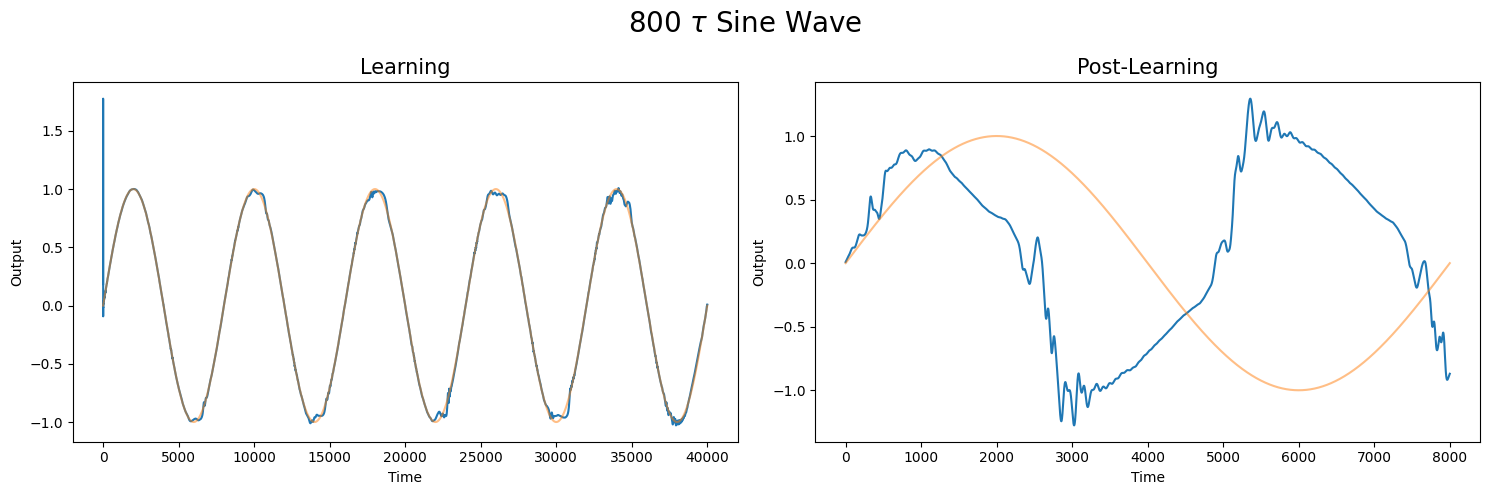

In [1258]:
# i_big_net = GenNetv2(1000, 1.0, 1.5, 0.1, 0.1)
# train_i_big, _, _, _, _ = i_big_net.train(big_tau_5, len(big_tau_5), 2)
# post_evol_i_big, _, _, _, _ = i_big_net.spontaneus_activity(8000)


fig = plt.figure(figsize=(15, 5))
gs = gridspec.GridSpec(1, 2)


ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])

ax1.plot(train_i_big)
ax1.plot(big_tau_5, alpha=0.5)
ax1.set_title('Learning', fontsize=15)
ax1.set_ylabel('Output')
ax1.set_xlabel('Time')

ax2.plot(post_evol_i_big)
ax2.plot(big_tau, alpha=0.5)
ax2.set_title('Post-Learning', fontsize=15)
ax2.set_ylabel('Output')
ax2.set_xlabel('Time')


fig.suptitle(r'800 $\tau$ Sine Wave', fontsize=20)
fig.tight_layout()
fig.savefig('big_sine_wave.png', dpi=600)

plt.show()


## Figure 3

In [1054]:
fd_4 = np.concatenate([f_d, f_d, f_d, f_d])
d_net = GenNetv2(1000, 1.0, 1.5, 0.1, 0.1)
train_evolution, neuron_dict, weight_array, weight_mag_array, activity_array = d_net.train(fd_4, len(fd_4), 2)
post_evol, post_n_dict, post_w_arr, post_w_mag_arr, post_act = d_net.spontaneus_activity(1440)

In [1417]:
pca = PCA()
scaler = StandardScaler()

activity_scaled = scaler.fit_transform(activity_array.T)

components = pca.fit_transform(activity_scaled)
features = range(pca.n_components_)


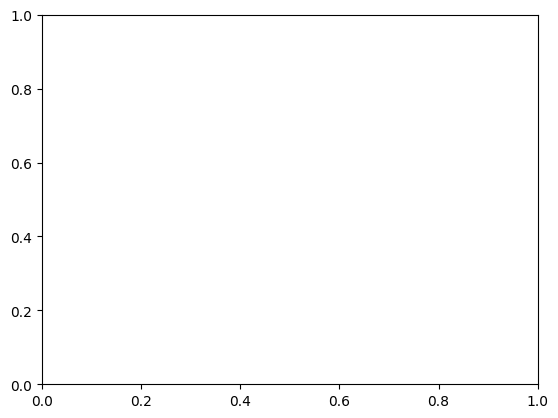

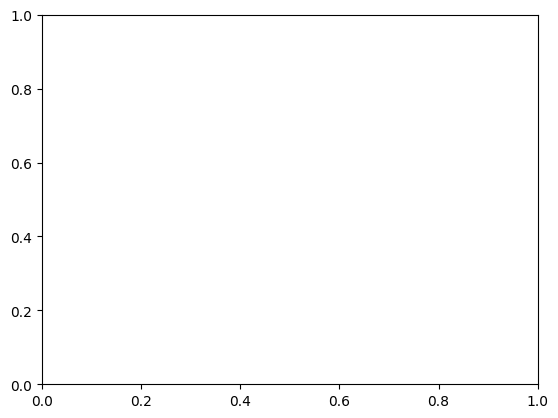

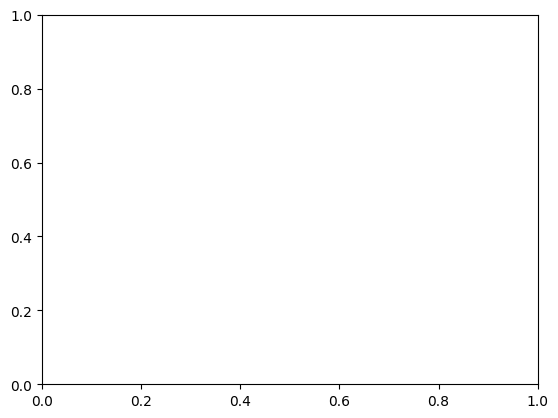

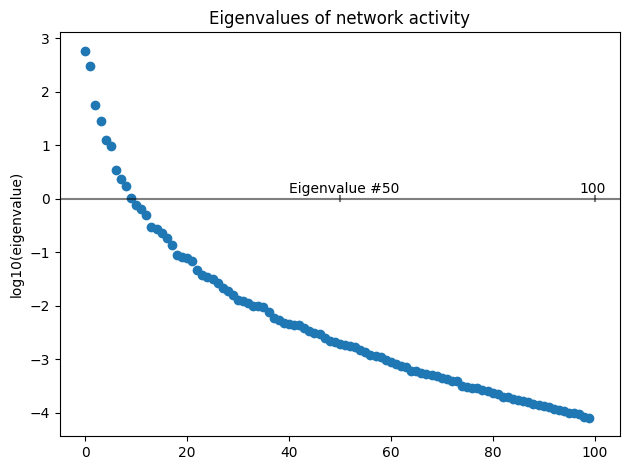

In [1418]:
fig, ax = plt.subplots()
# plt.rcParams['axes.spines.left'] = True
# plt.rcParams['axes.spines.right'] = False
# plt.rcParams['axes.spines.top'] = False
# # plt.rcParams['axes.spines.bottom'] = False
# plt.rcParams['xtick.bottom'] = False
# plt.rcParams['xtick.labelbottom'] = False
ax.scatter(range(0,100),np.log10(pca.explained_variance_[:100]),marker='o') 
ax.axhline(0,0,100, color='black', alpha=0.5)
ax.text(97, 0.1, '100', color='black', fontsize=10)
ax.plot([100, 100], [-0.05, 0.05], color='black', alpha=0.5)
ax.text(40, 0.1, 'Eigenvalue #50', color='black', fontsize=10)
ax.plot([50, 50], [-0.05, 0.05], color='black', alpha=0.5)
ax.set_ylabel('log10(eigenvalue)')
ax.set_title('Eigenvalues of network activity')
fig.tight_layout()
fig.savefig('pca_evs.png', dpi=600)
plt.show()

In [1057]:
# 30 works way better though
recon_transform = scaler.inverse_transform(components[:, :8]@pca.components_[:8, :])

In [1058]:
recon_output = np.zeros(1440)
for i in range(1440):
    recon_output[i] = weight_array.T[i, :]@ recon_transform[i, : ]



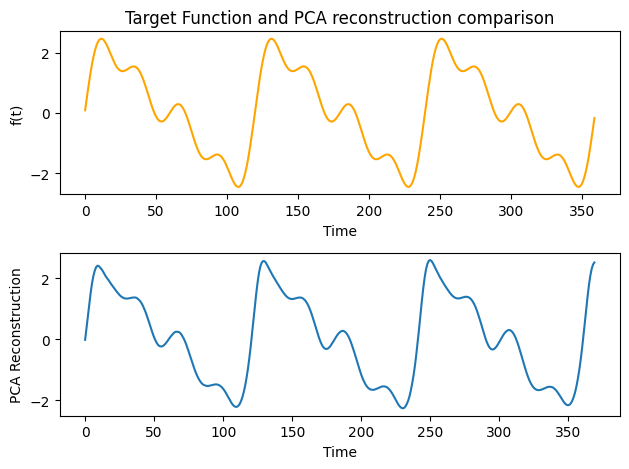

In [1413]:
fig = plt.figure()
gs = gridspec.GridSpec(2, 1)
ax = fig.add_subplot(gs[0, 0])
ax.plot(f_d[360:720], color='orange')
ax.set_xlabel('Time')
ax.set_ylabel('f(t)')
ax.set_title('Target Function and PCA reconstruction comparison')

ax2 = fig.add_subplot(gs[1, 0])
ax2.plot(recon_output[360:730])
ax2.set_xlabel('Time')
ax2.set_ylabel('PCA Reconstruction')


fig.tight_layout()
fig.savefig('reconstruction.png', dpi=600)
plt.show()

## Projecting onto first 8 prinicple components

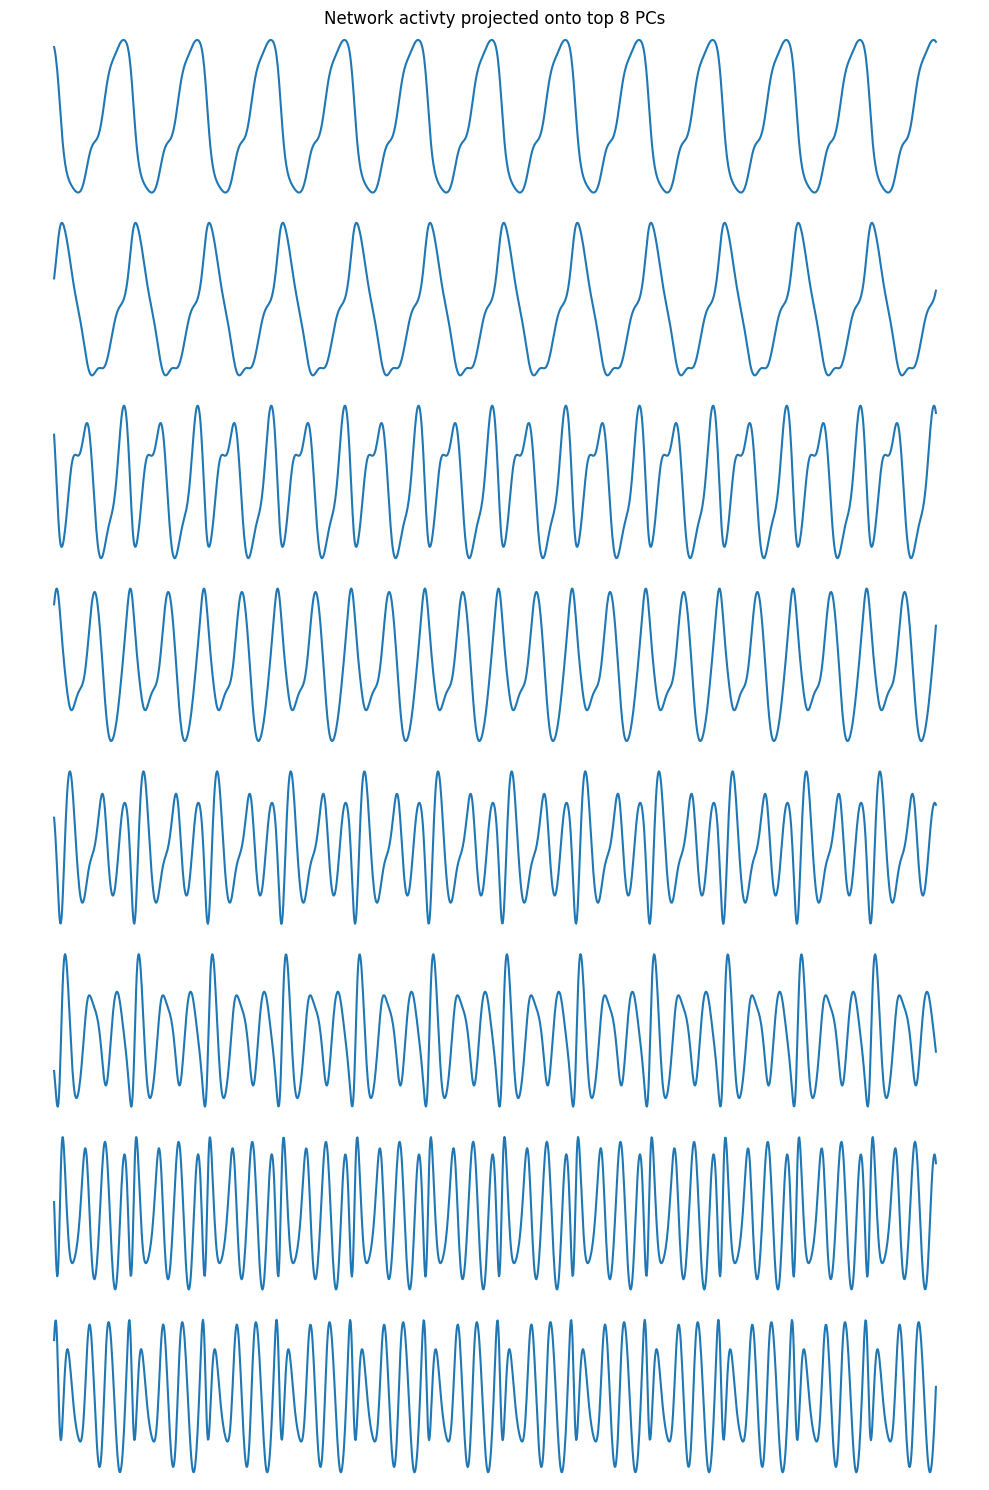

In [1409]:
# num_pcs = 8

# pca = PCA()
# scaler = StandardScaler()

# activity_scaled = scaler.fit_transform(post_act.T)

# components = pca.fit_transform(activity_scaled)
# features = range(pca.n_components_)

# projections = components[:,:num_pcs] 

#plot activity 
fig, ax = plt.subplots(num_pcs, 1, figsize=(10,15), sharex=True)

for i in range(num_pcs): 
    ax[i].plot(projections[:,i]) 
    ax[i].set_ylabel(f'PC{i+1}')
    ax[i].axis('off')
    ax[i].set_frame_on(False)

ax[0].set_title('Network activty projected onto top 8 PCs')

fig.tight_layout()
fig.savefig('top_8_projection.png', dpi=600)
plt.show()

## Evolution of w

In [1383]:
d1_net = GenNetv2(1000, 1.0, 1.5, 0.1, 0.1)
d1_net.spontaneus_activity(200)
_, _, weight_array_1, _, activity_array_1 = d1_net.train(f_d, len(f_d), 2)

d2_net = GenNetv2(1000, 1.0, 1.5, 0.1, 0.1)
d2_net.spontaneus_activity(200)
_, _, weight_array_2, _, activity_array_2 = d2_net.train(f_d, len(f_d), 2)


d3_net = GenNetv2(1000, 1.0, 1.5, 0.1, 0.1)
d3_net.spontaneus_activity(200)
_, _, weight_array_3, _, activity_array_3 = d3_net.train(f_d, len(f_d), 2)


d4_net = GenNetv2(1000, 1.0, 1.5, 0.1, 0.1)
d4_net.spontaneus_activity(200)
_, _, weight_array_4, _, activity_array_4 = d4_net.train(f_d, len(f_d), 2)


d5_net = GenNetv2(1000, 1.0, 1.5, 0.1, 0.1)
d5_net.spontaneus_activity(200)
_, _, weight_array_5, _, activity_array_5 = d5_net.train(f_d, len(f_d), 2)


pca_w_1 = PCA(n_components=2)
scaler_1 = StandardScaler()
scaled_activity_1 = scaler_1.fit_transform(activity_array_1.T)
pca_w_1.fit_transform(scaled_activity_1)

pca_w_2 = PCA(n_components=2)
scaler_2 = StandardScaler()
scaled_activity_2 = scaler_2.fit_transform(activity_array_2.T)
pca_w_2.fit_transform(scaled_activity_2)

pca_w_3 = PCA(n_components=2)
scaler_3 = StandardScaler()
scaled_activity_3 = scaler_3.fit_transform(activity_array_3.T)
pca_w_3.fit_transform(scaled_activity_3)

pca_w_4 = PCA(n_components=2)
scaler_4 = StandardScaler()
scaled_activity_4 = scaler_4.fit_transform(activity_array_4.T)
pca_w_4.fit_transform(scaled_activity_4)

pca_w_5 = PCA(n_components=2)
scaler_5 = StandardScaler()
scaled_activity_5 = scaler_5.fit_transform(activity_array_5.T)
pca_w_5.fit_transform(scaled_activity_5)

array([[-1.42696774, -1.56900919],
       [-1.39605945, -1.59420863],
       [-1.36321808, -1.61701445],
       ...,
       [35.09623791, 11.56763783],
       [34.27794834, 13.02648077],
       [33.18833875, 14.68749813]])

In [1384]:
ws1 =StandardScaler().fit_transform(weight_array_1)
ws2 =StandardScaler().fit_transform(weight_array_2)
ws3 =StandardScaler().fit_transform(weight_array_3)
ws4 =StandardScaler().fit_transform(weight_array_4)
ws5 =StandardScaler().fit_transform(weight_array_5)


In [1386]:
pc1_1, pc2_1 = pca_w_1.components_
projection_1_1 = ws1.T @ pc1_1
projection_2_1 = ws1.T @ pc2_1

pc1_2, pc2_2 = pca_w_2.components_
projection_1_2 = ws2.T @ pc1_2
projection_2_2 = ws2.T @ pc2_2

pc1_3, pc2_3 = pca_w_3.components_
projection_1_3 = ws3.T @ pc1_3
projection_2_3 = ws3.T @ pc2_3

pc1_4, pc2_4 = pca_w_4.components_
projection_1_4 = ws4.T @ pc1_4
projection_2_4 = ws4.T @ pc2_4

pc1_5, pc2_5 = pca_w_5.components_
projection_1_5 = ws5.T @ pc1_5
projection_2_5 = ws5.T @ pc2_5

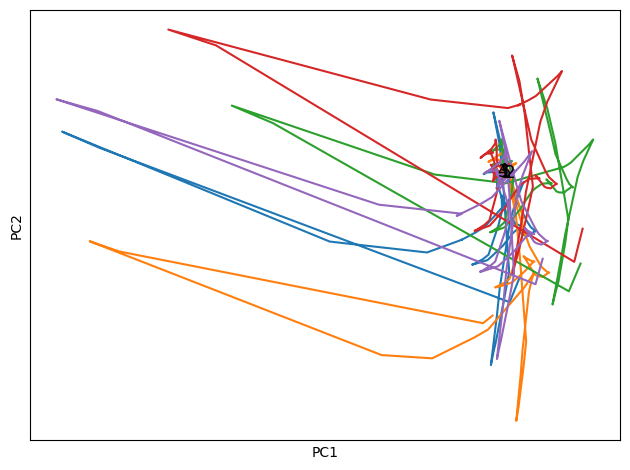

In [1390]:
fig, ax = plt.subplots()

ax.plot(projection_1_1, projection_2_1)
ax.text(projection_1_1[-1], projection_2_1[-1], '1', fontsize=12)
ax.plot(projection_1_2, projection_2_2)
ax.text(projection_1_2[-1], projection_2_2[-1], '2', fontsize=12)
ax.plot(projection_1_3, projection_2_3)
ax.text(projection_1_3[-1], projection_2_3[-1], '3', fontsize=12)
ax.plot(projection_1_4, projection_2_4)
ax.text(projection_1_4[-1], projection_2_4[-1], '4', fontsize=12)
ax.plot(projection_1_5, projection_2_5)
ax.text(projection_1_5[-1], projection_2_5[-1], '5', fontsize=12)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_xticks([])
ax.set_yticks([])
ax.grid()

fig.tight_layout()
fig.savefig('pca_weight.png', dpi=600)
plt.show()



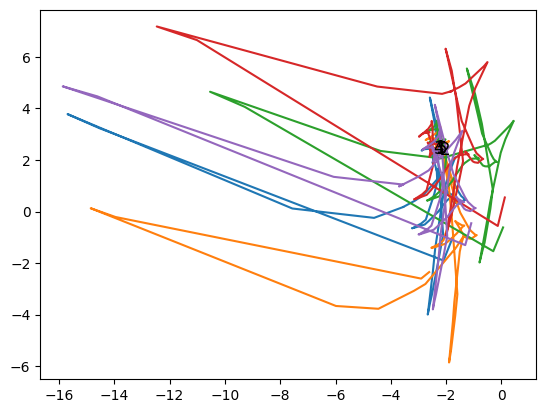

In [1388]:
total_activty = np.concatenate((activity_array_1, activity_array_2, activity_array_3, activity_array_4, activity_array_5), axis=1)

pca = PCA(n_components=2)
scaler = StandardScaler()
scaled_activity = scaler.fit_transform(total_activty.T)
pca.fit_transform(scaled_activity)

pc1, pc2 = pca.components_



projection_1_1 = ws1.T @ pc1
projection_2_1 = ws1.T @ pc2

projection_1_2 = ws2.T @ pc1
projection_2_2 = ws2.T @ pc2

projection_1_3 = ws3.T @ pc1
projection_2_3 = ws3.T @ pc2

projection_1_4 = ws4.T @ pc1
projection_2_4 = ws4.T @ pc2

projection_1_5 = ws5.T @ pc1
projection_2_5 = ws5.T @ pc2

v=0
plt.plot(projection_1_1[v:], projection_2_1[v:])
plt.text(projection_1_1[-1], projection_2_1[-1], '1', fontsize=12)
plt.plot(projection_1_2[v:], projection_2_2[v:])
plt.text(projection_1_2[-1], projection_2_2[-1], '2', fontsize=12)
plt.plot(projection_1_3[v:], projection_2_3[v:])
plt.text(projection_1_3[-1], projection_2_3[-1], '3', fontsize=12)
plt.plot(projection_1_4[v:], projection_2_4[v:])
plt.text(projection_1_4[-1], projection_2_4[-1], '4', fontsize=12)
plt.plot(projection_1_5[v:], projection_2_5[v:])
plt.text(projection_1_5[-1], projection_2_5[-1], '5', fontsize=12)

plt.show()